# Copyright & Acknowledgements

# Time Series Forecasting Project

# Setup

## Load Libraries

In [42]:
import numpy as np
import pandas as pd
from datetime import datetime
import os

import IPython
import IPython.display

from sklearn.neural_network import MLPRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow.data.Dataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX


from prophet import Prophet

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Set Plotting Styles
#plt.style.use('ggplot')

## Load Dataset

In [2]:
# Define location of datasets
path = "C:\\Users\\coope\\Data_Science\\Datasets\\Energy"

# Load in data
energy = pd.read_csv(path + '\hrl_load_metered.csv', index_col=[0], parse_dates=[0])
energy_t1 = pd.read_csv(path + '\hrl_load_metered - test1.csv', index_col=[0], parse_dates=[0])
energy_t2 = pd.read_csv(path + '\hrl_load_metered - test2.csv', index_col=[0], parse_dates=[0])
energy_t3 = pd.read_csv(path + '\hrl_load_metered - test3.csv', index_col=[1], parse_dates=[1])
energy_t4 = pd.read_csv(path + '\hrl_load_metered - test4.csv', index_col=[0], parse_dates=[0])
energy_t5 = pd.read_csv(path + '\hrl_load_metered - test5.csv', index_col=[0], parse_dates=[0])

energy_t3 = energy_t3.drop(['datetime_beginning_utc'], axis = 1)

# Combine dataframes for cleaning dataset
total_energy = pd.concat([energy, energy_t1, energy_t2, energy_t3, energy_t4, energy_t5])

total_energy.head(10)

,nerc_region,mkt_region,zone,load_area,mw,is_verified
datetime_beginning_ept,,,,,,
2016-01-01 00:00:00,RFC,WEST,AEP,AEPAPT,4064.992,True
2016-01-01 01:00:00,RFC,WEST,AEP,AEPAPT,4023.104,True
2016-01-01 02:00:00,RFC,WEST,AEP,AEPAPT,4009.598,True
2016-01-01 03:00:00,RFC,WEST,AEP,AEPAPT,4004.521,True
2016-01-01 04:00:00,RFC,WEST,AEP,AEPAPT,4080.944,True
2016-01-01 05:00:00,RFC,WEST,AEP,AEPAPT,4177.135,True
2016-01-01 06:00:00,RFC,WEST,AEP,AEPAPT,4316.690,True
2016-01-01 07:00:00,RFC,WEST,AEP,AEPAPT,4471.222,True
2016-01-01 08:00:00,RFC,WEST,AEP,AEPAPT,4574.792,True


# Preprocessing & Cleanup

In [3]:
# Drop unnessesary columns
aep_df = total_energy.drop(columns = ["nerc_region", "zone", "mkt_region", "load_area", "is_verified"])

# Rename Index
aep_df.index.names = ["Datetime"]

# Sort Data
aep_df.sort_index(inplace = True)

# Identify Duplicate Indices
duplicate_index = aep_df[aep_df.index.duplicated()]
print(aep_df.loc[duplicate_index.index.values, :])

# Replace Duplicates with Mean Value
aep_df = aep_df.groupby('Datetime').agg(np.mean)

#Set Datetime Index Frequency
aep_df = aep_df.asfreq('H')

# Determine # of Missing Values
print('# of Missing df_MW Values:{}'.format(len(aep_df[aep_df['mw'].isna()])))

# Impute Missing Values
aep_df['mw'] = aep_df['mw'].interpolate(limit_area = 'inside', limit = None)

                           mw
Datetime                     
2016-11-06 01:00:00  3608.340
2016-11-06 01:00:00  3608.197
2017-11-05 01:00:00  3296.872
2017-11-05 01:00:00  3251.448
2018-11-04 01:00:00  4073.050
2018-11-04 01:00:00  4089.423
2019-11-03 01:00:00  4067.316
2019-11-03 01:00:00  4053.021
2020-11-01 01:00:00  3704.506
2020-11-01 01:00:00  3656.434
2021-11-07 01:00:00  4042.513
2021-11-07 01:00:00  4081.986
2022-11-06 01:00:00  3091.819
2022-11-06 01:00:00  3028.478
# of Missing df_MW Values:8


## EDA

In [4]:
aep_df.head(10)

,mw
Datetime,
2016-01-01 00:00:00,4064.992
2016-01-01 01:00:00,4023.104
2016-01-01 02:00:00,4009.598
2016-01-01 03:00:00,4004.521
2016-01-01 04:00:00,4080.944
2016-01-01 05:00:00,4177.135
2016-01-01 06:00:00,4316.690
2016-01-01 07:00:00,4471.222
2016-01-01 08:00:00,4574.792


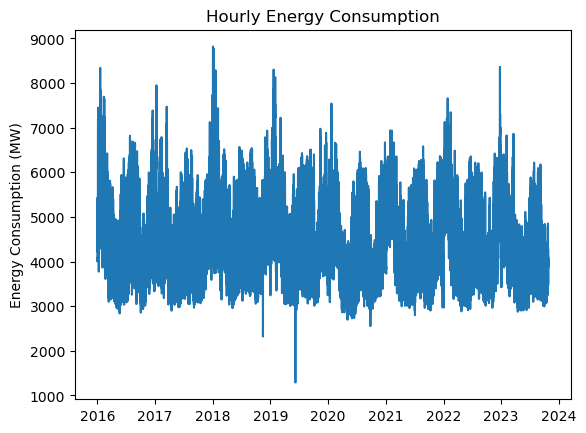

In [5]:
## Visualize Energy Consumption
plt.plot(aep_df.index, aep_df['mw'])
plt.title('Hourly Energy Consumption')
plt.ylabel('Energy Consumption (MW)')
plt.show()

In [6]:
aep_df.describe()

,mw
count,68520.00000
mean,4442.80571
std,836.47753
min,1289.92300
25%,3826.72700
50%,4306.42800
75%,4984.94750
max,8820.49600


# Forecasting 24 Hours Ahead

## Time Series Modeling with statsmodels

### Train/Test Split

In [45]:
# Create Train and Test Datasets
train = aep_df.head(len(aep_df) - 168)
test_24 = aep_df.tail(168).head(24)

### Exponential Smooting Models

In [21]:
# Create and fit Holt-Winters ESM
HW_Model = ExponentialSmoothing(train.values, seasonal_periods = 24, trend = None, seasonal = 'mul')
HW_model_fit = HW_Model.fit()
#print(HW_model_fit.mle_retvals)

C:\Users\coope\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [22]:
# Generate Forecast
HW_pred = HW_model_fit.forecast(steps = len(test_24))
HW_pred_series = pd.Series(HW_pred, index = test_24.index)

# Evaluate Model
HW_mae = mae(test_24, HW_pred_series)
HW_mape = mape(test_24, HW_pred_series)

print(HW_mae)
print(HW_mape)

247.74293801542694
0.0618504303237214


### Seasonal ARIMA (SARIMA)

In [ ]:
## Seasonal ARIMA
model1 = pm.auto_arima(train, start_p = 1, start_q = 5, start_P = 2, start_Q = 0, d = None, D = 1, seasonal = True, m = 24, Trace = True)
model1.summary()

MemoryError: Unable to allocate 2.71 GiB for an array with shape (73, 73, 68353) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1014, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 2.71 GiB for an array with shape (73, 73, 68353) and data type float64


### Prophet

In [23]:
# Prophet Model

## Process Data to Use Prophet
train_df = pd.DataFrame(train).reset_index(drop = False)
train_df.columns = ['ds', 'y']

# Create model, assuming multiplicative seasonality. 
prophet_model = Prophet(seasonality_mode = 'multiplicative', yearly_seasonality = False)
###prophet_model = Prophet(seasonality_mode = 'additive')

# Add U.S. holiday effects
prophet_model.add_country_holidays(country_name = 'US')

# Add Custom Seasonality
prophet_model.add_seasonality(name = "Yearly", period = 365.25, fourier_order = 2)

# Train model
prophet_model.fit(train_df)

20:43:46 - cmdstanpy - INFO - Chain [1] start processing
20:44:15 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
# Generate forecasts
future = prophet_model.make_future_dataframe(periods = len(test_24), freq = 'H')
forecast = prophet_model.predict(future)

prophet_preds = forecast['yhat'][-24:].values

In [35]:
# Evaluate performance
mape_score = mape(test.values, prophet_preds)
print(mape_score)

mae_score = mae(test.values, prophet_preds)
print(mae_score)

error_prophet = test_24["mw"].values - forecast['yhat'].tail(24).values
MAPE = np.mean(abs(error_prophet) / test_24["mw"].values)*100
print(MAPE)

0.0589276860328559
231.80385705774333
5.89276860328559


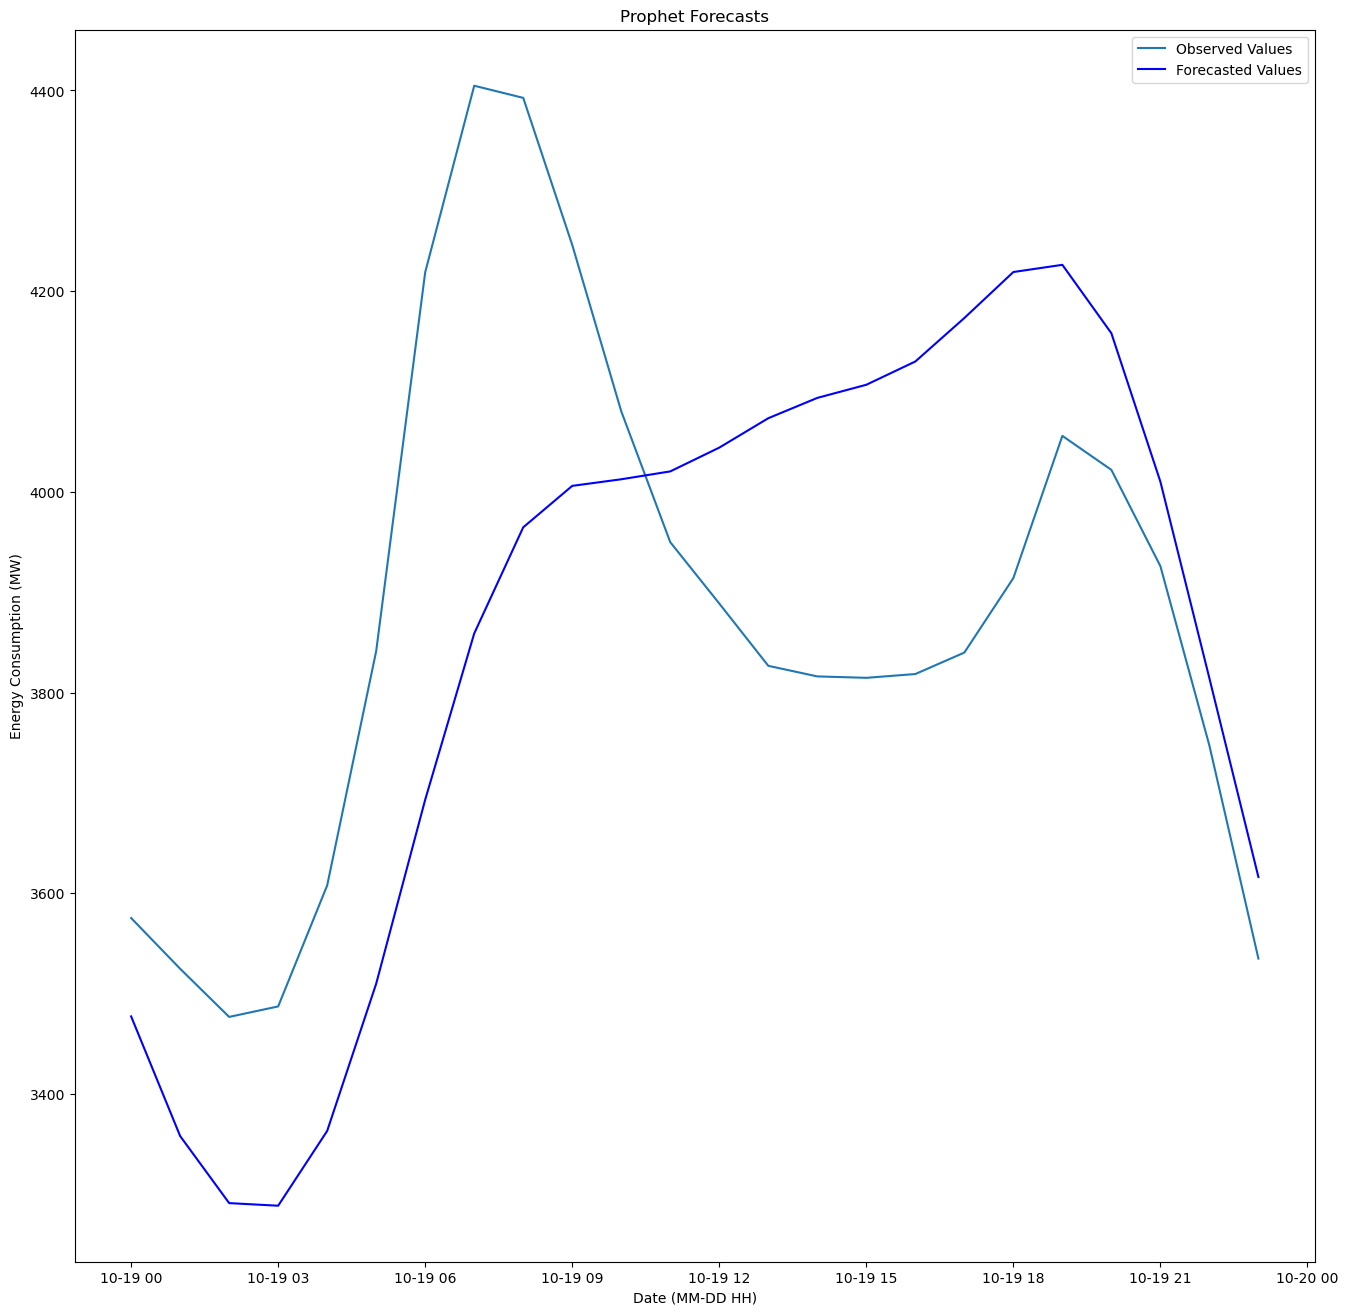

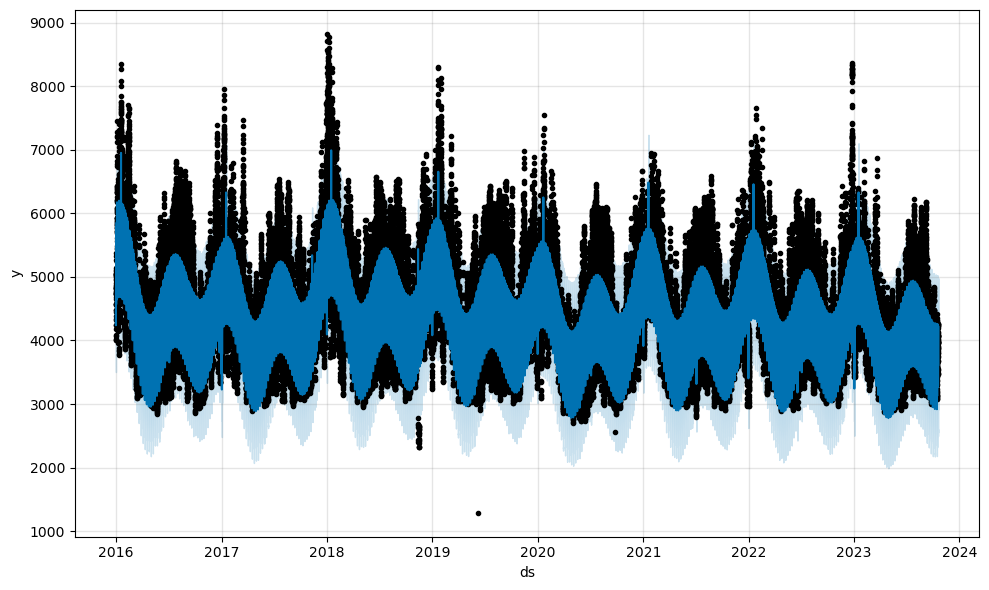

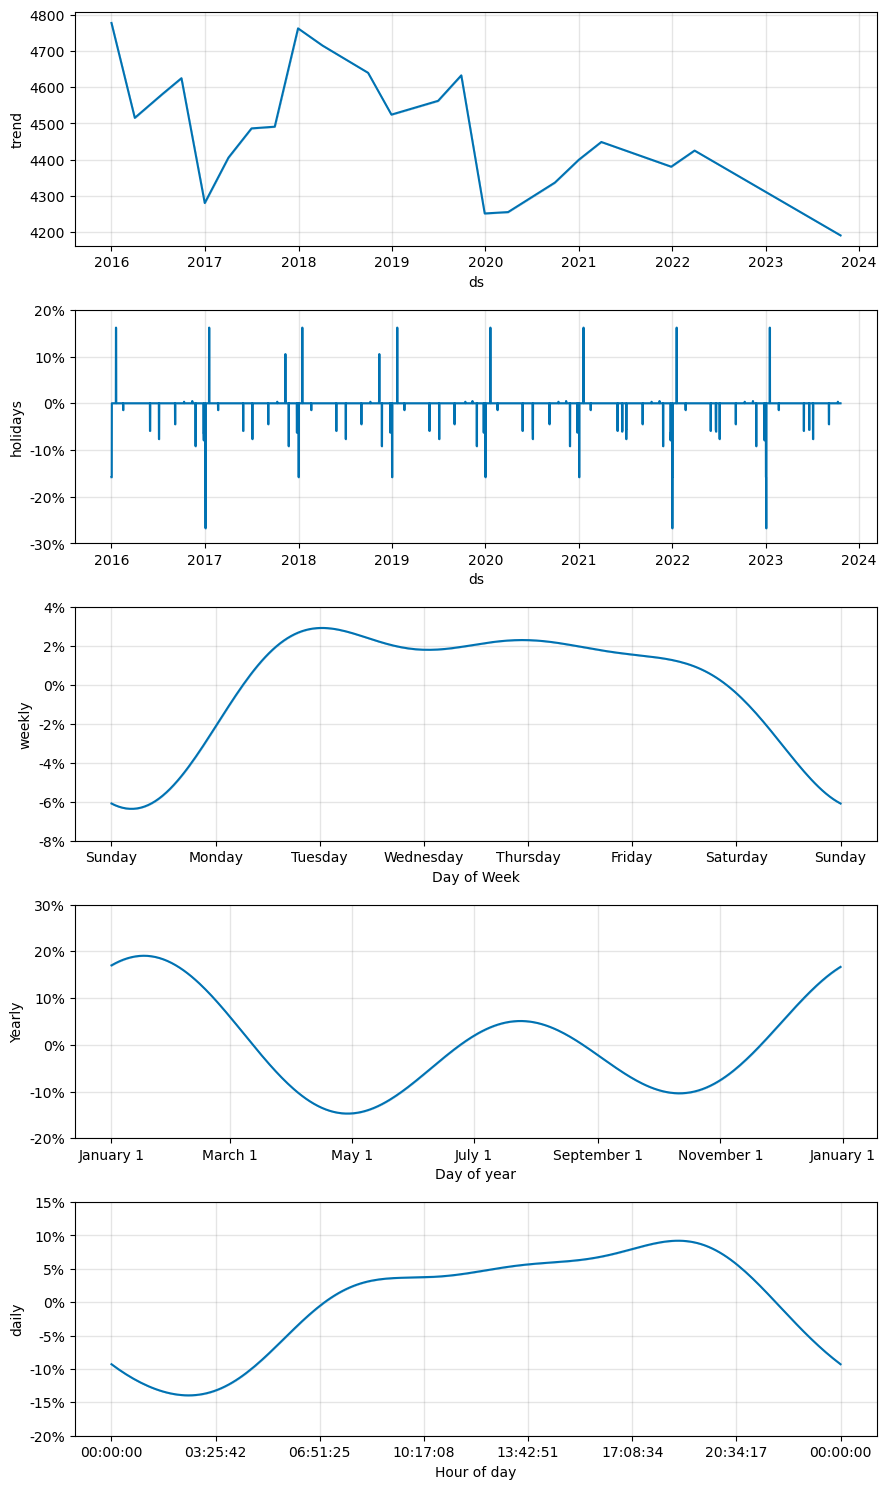

In [36]:
# Graph Model
fig, axes = plt.subplots(figsize = (16, 16))

prophet_preds_series = pd.Series(prophet_preds, index = test.index)

axes.plot(test, label = 'Observed Values')
axes.plot(prophet_preds_series, color = 'blue', label = 'Forecasted Values')
plt.xlabel('Date (MM-DD HH)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
axes.title.set_text('Prophet Forecasts')

fig = prophet_model.plot(forecast)
plt.show()

fig = prophet_model.plot_components(forecast)

### Autoregressive Neural Network

In [37]:
# Create Train and Test Datasets
"""
train = aep_df.head(len(aep_df) - 168)
test = aep_df.tail(168)
"""
# Create Train and Test Datasets
train = train
test = test_24

In [38]:
# Add in lagged terms for train data
train['diff'] = train['mw'] - train['mw'].shift(24)
train['L1'] = train['diff'].shift()
train['L2'] = train['diff'].shift(2)
train['L24'] = train['diff'].shift(24)
train['L48'] = train['diff'].shift(48)

C:\Users\coope\AppData\Local\Temp\ipykernel_10700\1683442129.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['diff'] = train['mw'] - train['mw'].shift(24)
C:\Users\coope\AppData\Local\Temp\ipykernel_10700\1683442129.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['L1'] = train['diff'].shift()
C:\Users\coope\AppData\Local\Temp\ipykernel_10700\1683442129.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

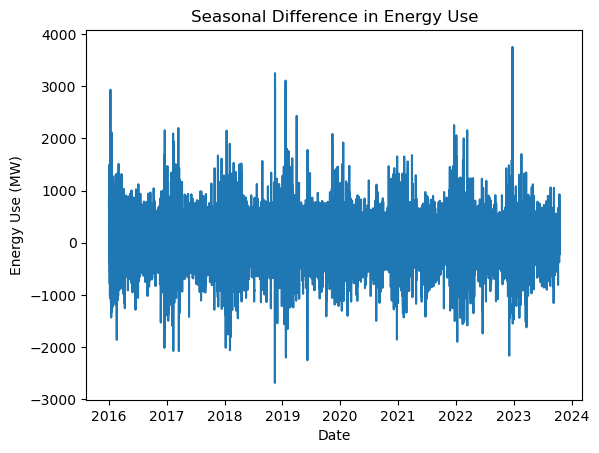

In [39]:
# Graph of differenced data
plt.cla()
plt.plot(train['diff'])
plt.xlabel("Date")
plt.ylabel("Energy Use (MW)")
plt.title("Seasonal Difference in Energy Use")
plt.show()

In [40]:
# Remove lags that are NA
train_clean = train.tail(len(train) - 72)


# Create Dataframe with only the last 48 hours
last_48 = train_clean.tail(48)



# Create training X and Y splits
X = train_clean.drop(['mw', 'diff'], axis = 1)
y = train_clean['diff']

In [43]:
# Create Neural Network using train dataset
NN_Energy = MLPRegressor(hidden_layer_sizes = (3,), random_state = 12345, max_iter = 100000).fit(X, y)

# Create date range for index
num_of_preds = 24
prediction_date_range = pd.date_range(start = train.index[-1], freq = 'H', periods = num_of_preds + 1)[1:num_of_preds + 1]


# Loop through 24 predictions
for i in range(0, num_of_preds):
    
    # Create lag variables
    l1 = last_48.iloc[-1, 1]
    l2 = last_48.iloc[-2, 1]
    l24 = last_48.iloc[-24, 1]
    l48 = last_48.iloc[-48, 1]
    
    X_test = pd.DataFrame(np.array([[l1, l2, l24, l48]]), columns = ['L1', 'L2', 'L24', 'L48'], index = [prediction_date_range[i]])
    
    # Predict next hour's energy load (differences in lags) and append
    nn_pred = NN_Energy.predict(X_test)
    X_test['diff'] = nn_pred
    
    # Calculate the energy load from the predicted difference and the energy load from 24 hours ago
    X_test['mw'] = nn_pred + last_48['mw'][-24]
    
    last_48 = pd.concat([last_48, X_test])



pred = last_48.tail(num_of_preds)


# MAPE for t1
error = test['mw'] - pred['mw']
MAPE = np.mean(abs(error)/test['mw'])*100
print(MAPE)

# MAE for t1
MAE = np.mean(abs(error))
print(MAE)

1.6743786011843687
65.27201271980368


# Forecasting 1 Week Ahead (168 Hours)